In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [23]:
# === Utility ===
def load_img_uint8(path):
    img = load_img(path, color_mode='grayscale', target_size=IMG_SIZE)
    return img_to_array(img).astype(np.uint8)

# === Index Dataset ===
def index_sequences(rtm_path, dtm_path, atm_path, seq_len=5, exclude=None):
    train, test, gestures = [], [], set()
    exclude = set(exclude or [])
    for person in sorted(os.listdir(rtm_path)):
        if person in exclude:
            target = test
        else:
            target = train
        for session in os.listdir(os.path.join(rtm_path, person)):
            for gesture in os.listdir(os.path.join(rtm_path, person, session)):
                rtm_files = sorted(glob(os.path.join(rtm_path, person, session, gesture, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_path, person, session, gesture, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_path, person, session, gesture, '*.png')))
                n = min(len(rtm_files), len(dtm_files), len(atm_files))
                gestures.add(gesture)
                for i in range(n - seq_len + 1):
                    target.append({
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'label': gesture
                    })
    label_map = {g: i for i, g in enumerate(sorted(gestures))}
    train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
    return train_data, val_data, test, label_map

# === Data Generator ===
class SingleInputSequence(Sequence):
    def __init__(self, samples, label_map, batch_size=64, seq_len=5, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __getitem__(self, idx):
        batch = self.samples[idx * self.batch_size: (idx + 1) * self.batch_size]
        X, y = [], []
        for sample in batch:
            rtm = [load_img_uint8(p) for p in sample['rtm']]
            dtm = [load_img_uint8(p) for p in sample['dtm']]
            atm = [load_img_uint8(p) for p in sample['atm']]
            sequence = np.concatenate(rtm + dtm + atm, axis=0)  # shape: (15*32, 32, 1)
            X.append(sequence)
            y.append(self.label_map[sample['label']])
        X = np.array(X).astype(np.float32) / 255.0  # shape: (B, 480, 32, 1)
        return X, np.array(y)

In [ ]:
def build_stm32_deployable_model(input_shape=(480, 32, 1), num_classes=13):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # === 1. Split Input ===
    rtm = layers.Cropping2D(((0, 320), (0, 0)))(inputs)     # 0:160
    dtm = layers.Cropping2D(((160, 160), (0, 0)))(inputs)   # 160:320
    atm = layers.Cropping2D(((320, 0), (0, 0)))(inputs)     # 320:480

    def cnn_branch():
        inp = tf.keras.Input(shape=(160, 32, 1))
        x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
        x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)  # 80x16x16

        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)  # 40x8x32

        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling2D()(x)  # -> (64,)
        return tf.keras.Model(inp, x)

    branch = cnn_branch()

    feat_rtm = branch(rtm)
    feat_dtm = branch(dtm)
    feat_atm = branch(atm)

    # === 2. Temporal Fusion (simulated LSTM) ===
    x = layers.Concatenate()( [feat_rtm, feat_dtm, feat_atm] )  # (192,)
    x = layers.Reshape((3, 64))(x)  # (3, 64)

    x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)  # instead of GlobalAvgPool1D

    # === 3. MLP Head ===
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [34]:
excluded = {f'p0_{i}' for i in range(15, 21)}  # Exclude p0_15 to p0_20
train_samples, val_samples, test_samples, label_map = index_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, seq_len=SEQ_LEN, exclude=excluded
)

# Instantiate generators
train_gen = SingleInputSequence(train_samples, label_map, batch_size=128, shuffle_data=True)
val_gen = SingleInputSequence(val_samples, label_map, batch_size=128, shuffle_data=False)

In [35]:
model = build_stm32_deployable_model(input_shape=(480, 32, 1), num_classes=13)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 480, 32, 1)]         0         []                            
                                                                                                  
 cropping2d_18 (Cropping2D)  (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                                  
 cropping2d_19 (Cropping2D)  (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                                  
 cropping2d_20 (Cropping2D)  (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                           

In [37]:
from collections import Counter
print("Train label distribution:", Counter([s['label'] for s in train_samples]))
print("Val label distribution:", Counter([s['label'] for s in val_samples]))


Train label distribution: Counter({'Push': 514, 'FastSwipeRL': 512, 'SlowSwipeRL': 510, 'Pull': 510, 'PalmHold': 510, 'Circle': 506, 'FingerRub': 501, 'PinchPinky': 497, 'PinchIndex': 497, 'PalmTilt': 496, 'RandomGesture': 495, 'FingerSlider': 480, 'NoHand': 461})
Val label distribution: Counter({'FingerSlider': 149, 'PinchIndex': 133, 'PinchPinky': 133, 'FingerRub': 129, 'PalmTilt': 127, 'NoHand': 124, 'Circle': 123, 'SlowSwipeRL': 120, 'PalmHold': 119, 'RandomGesture': 118, 'Pull': 117, 'Push': 116, 'FastSwipeRL': 115})


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=40)

Epoch 1/40
51/51 [==============================] - 32s 619ms/step - loss: 2.4446 - accuracy: 0.1262 - val_loss: 2.0355 - val_accuracy: 0.2606
Epoch 2/40
51/51 [==============================] - 30s 597ms/step - loss: 1.7179 - accuracy: 0.3646 - val_loss: 1.6192 - val_accuracy: 0.4005
Epoch 3/40
51/51 [==============================] - 30s 598ms/step - loss: 1.5699 - accuracy: 0.4166 - val_loss: 1.5286 - val_accuracy: 0.4048
Epoch 4/40
51/51 [==============================] - 31s 611ms/step - loss: 1.5001 - accuracy: 0.4313 - val_loss: 1.4934 - val_accuracy: 0.4276
Epoch 5/40
51/51 [==============================] - 30s 597ms/step - loss: 1.4675 - accuracy: 0.4443 - val_loss: 1.4975 - val_accuracy: 0.4344
Epoch 6/40
51/51 [==============================] - 30s 591ms/step - loss: 1.4456 - accuracy: 0.4617 - val_loss: 1.4359 - val_accuracy: 0.4461
Epoch 7/40
51/51 [==============================] - 30s 594ms/step - loss: 1.3979 - accuracy: 0.4751 - val_loss: 1.4292 - val_accuracy: 0.4529

In [42]:
model.save('deployable_cnn_model.h5')

c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
label_map

{'Circle': 0,
 'FastSwipeRL': 1,
 'FingerRub': 2,
 'FingerSlider': 3,
 'NoHand': 4,
 'PalmHold': 5,
 'PalmTilt': 6,
 'PinchIndex': 7,
 'PinchPinky': 8,
 'Pull': 9,
 'Push': 10,
 'RandomGesture': 11,
 'SlowSwipeRL': 12}

3/3 [==============================] - 0s 10ms/step


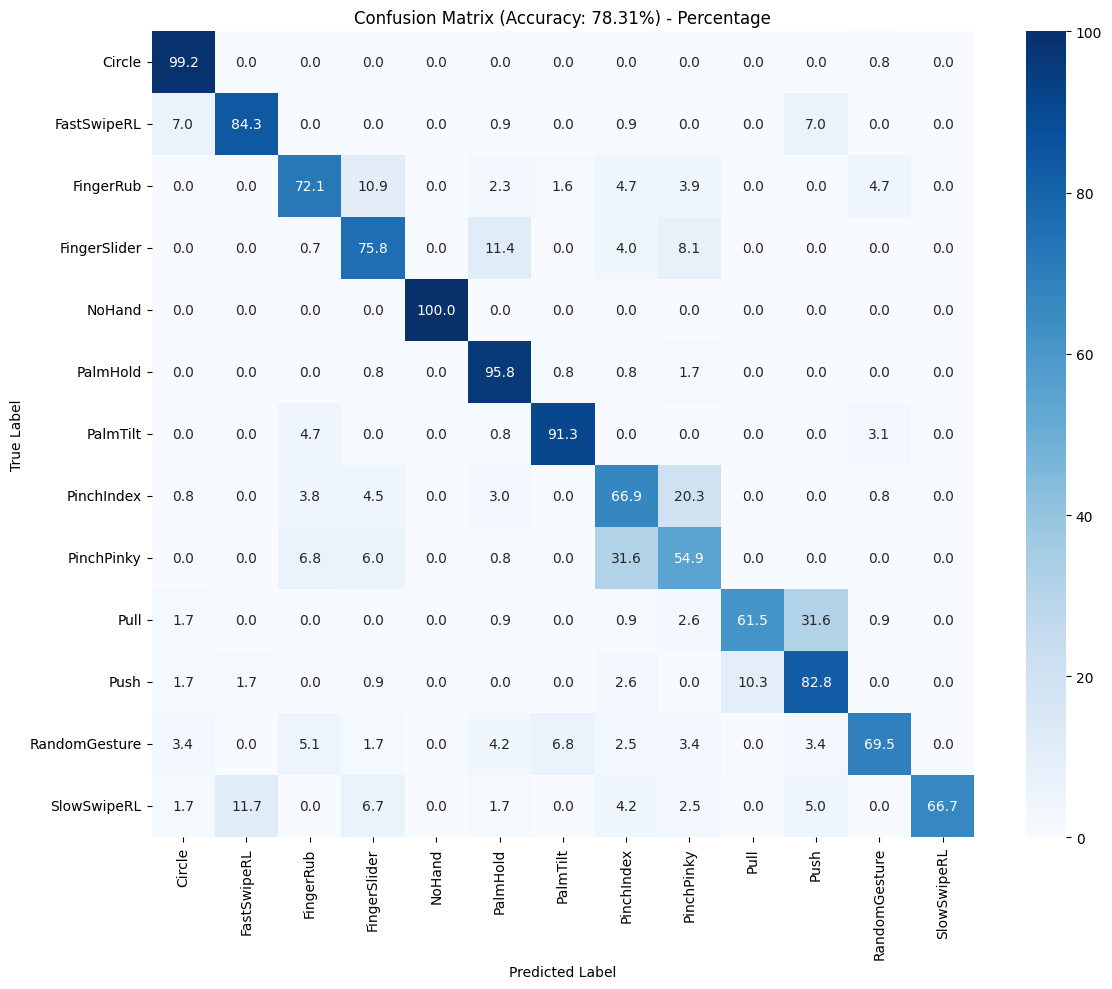

               precision    recall  f1-score   support

       Circle      0.865     0.992     0.924       123
  FastSwipeRL      0.858     0.843     0.851       115
    FingerRub      0.775     0.721     0.747       129
 FingerSlider      0.739     0.758     0.748       149
       NoHand      1.000     1.000     1.000       124
     PalmHold      0.765     0.958     0.851       119
     PalmTilt      0.913     0.913     0.913       127
   PinchIndex      0.567     0.669     0.614       133
   PinchPinky      0.566     0.549     0.557       133
         Pull      0.857     0.615     0.716       117
         Push      0.636     0.828     0.719       116
RandomGesture      0.863     0.695     0.770       118
  SlowSwipeRL      1.000     0.667     0.800       120

     accuracy                          0.783      1623
    macro avg      0.800     0.785     0.785      1623
 weighted avg      0.797     0.783     0.783      1623



In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

exclude_labels = {}
label_to_idx = {label: idx for label, idx in label_map.items() if label not in exclude_labels}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Inverse mapping for lookup
valid_indices = set(label_to_idx.values())

y_true, y_pred = [], []
for X, y in val_gen:
    preds = model.predict(X)
    for true_label, pred_logits in zip(y, preds):
        if int(true_label) in valid_indices:
            y_true.append(int(true_label))
            y_pred.append(np.argmax(pred_logits))

# Reindex labels to remove gaps caused by excluded labels
original_to_new_idx = {old: new for new, old in enumerate(sorted(valid_indices))}
new_class_names = [idx_to_label[i] for i in sorted(valid_indices)]

# Remap y_true and y_pred
y_true_mapped = [original_to_new_idx[y] for y in y_true]
y_pred_mapped = [original_to_new_idx[y] for y in y_pred]

# Metrics
cm = confusion_matrix(y_true_mapped, y_pred_mapped)
acc = accuracy_score(y_true_mapped, y_pred_mapped)
report = classification_report(y_true_mapped, y_pred_mapped, target_names=new_class_names, digits=3)

# Normalize the confusion matrix row-wise to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=new_class_names, yticklabels=new_class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2%}) - Percentage")
plt.tight_layout()
plt.show()

# Print classification report
print(report)

# Converting to TFLite

In [58]:
# Reload it to ensure clean state
model = tf.keras.models.load_model("deployable_cnn_model.h5")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.evaluate(val_gen)

13/13 [==============================] - 7s 438ms/step - loss: 0.5506 - accuracy: 0.7831


[0.5506397485733032, 0.7831177115440369]

In [ ]:
# === Wrap with fixed batch size ===
fixed_input = tf.keras.Input(batch_input_shape=(1, 480, 32, 1), name="input")
fixed_output = model(fixed_input)
wrapped_model = tf.keras.Model(inputs=fixed_input, outputs=fixed_output)

# === Save as TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_model)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
with open("deployable_cnn_model_float32.tflite", "wb") as f:
    f.write(tflite_model)

print(" Model wrapped and saved with fixed batch size: (1, 480, 32, 1)")

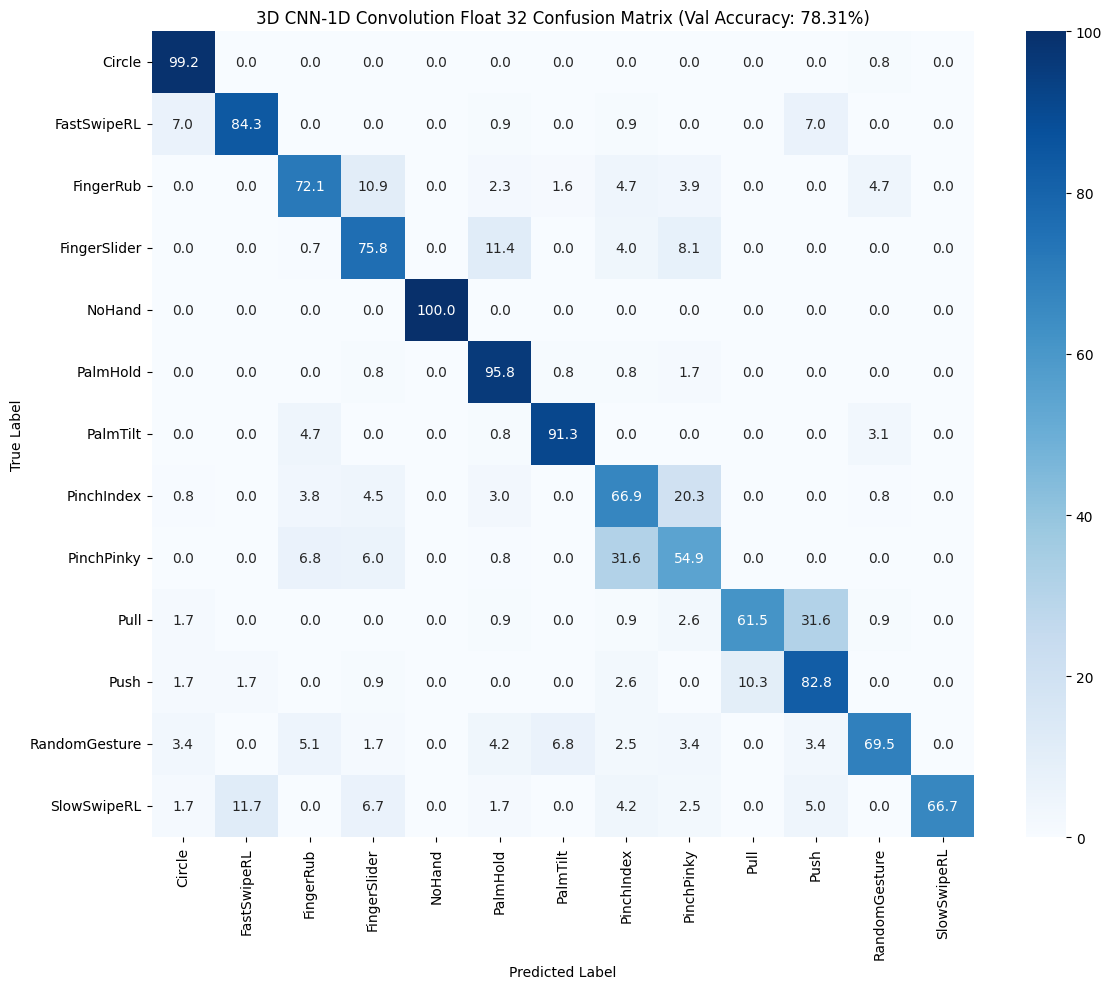

Classification Report:
                precision    recall  f1-score   support

       Circle      0.865     0.992     0.924       123
  FastSwipeRL      0.858     0.843     0.851       115
    FingerRub      0.775     0.721     0.747       129
 FingerSlider      0.739     0.758     0.748       149
       NoHand      1.000     1.000     1.000       124
     PalmHold      0.765     0.958     0.851       119
     PalmTilt      0.913     0.913     0.913       127
   PinchIndex      0.567     0.669     0.614       133
   PinchPinky      0.566     0.549     0.557       133
         Pull      0.857     0.615     0.716       117
         Push      0.636     0.828     0.719       116
RandomGesture      0.863     0.695     0.770       118
  SlowSwipeRL      1.000     0.667     0.800       120

     accuracy                          0.783      1623
    macro avg      0.800     0.785     0.785      1623
 weighted avg      0.797     0.783     0.783      1623



In [93]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="deployable_cnn_model_float32.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using TFLite
def predict_tflite_sequence(sequence):
    # Ensure float32 and normalized
    sequence = sequence.astype(np.float32)
    # Add batch dimension
    input_tensor = np.expand_dims(sequence, axis=0)  
    # Set tensor and invoke
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    # Extract prediction
    output = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output, axis=1)[0]

# Evaluate on val set
y_true, y_pred = [], []
for X, y in val_gen:
    for i in range(len(X)):
        pred = predict_tflite_sequence(X[i])
        y_true.append(int(y[i]))
        y_pred.append(int(pred))

# Get full label list
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(label_map))]

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# Normalize CM to show percentages
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"3D CNN-1D Convolution Float 32 Confusion Matrix (Val Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:\n", report)

# Quantizing to Int8

In [ ]:
# === Fixed batch-size wrapper ===
fixed_input = tf.keras.Input(batch_input_shape=(1, 480, 32, 1), name="input")
fixed_output = model(fixed_input)
wrapped_model = tf.keras.Model(inputs=fixed_input, outputs=fixed_output)

# === Representative dataset: yield one sample with correct shape (1, 480, 32, 1) ===
def representative_dataset():
    for i in range(100):
        x, _ = train_gen[i]
        for sample in x:
            sample = sample.astype(np.float32)
            yield [np.expand_dims(sample, axis=0)]  # shape: (1, 480, 32, 1)

# === Convert model to full INT8 with fixed shape ===
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert and save
tflite_model = converter.convert()
with open("deployable_cnn_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("Full INT8 TFLite model saved with fixed batch size: (1, 480, 32, 1)")


Testing

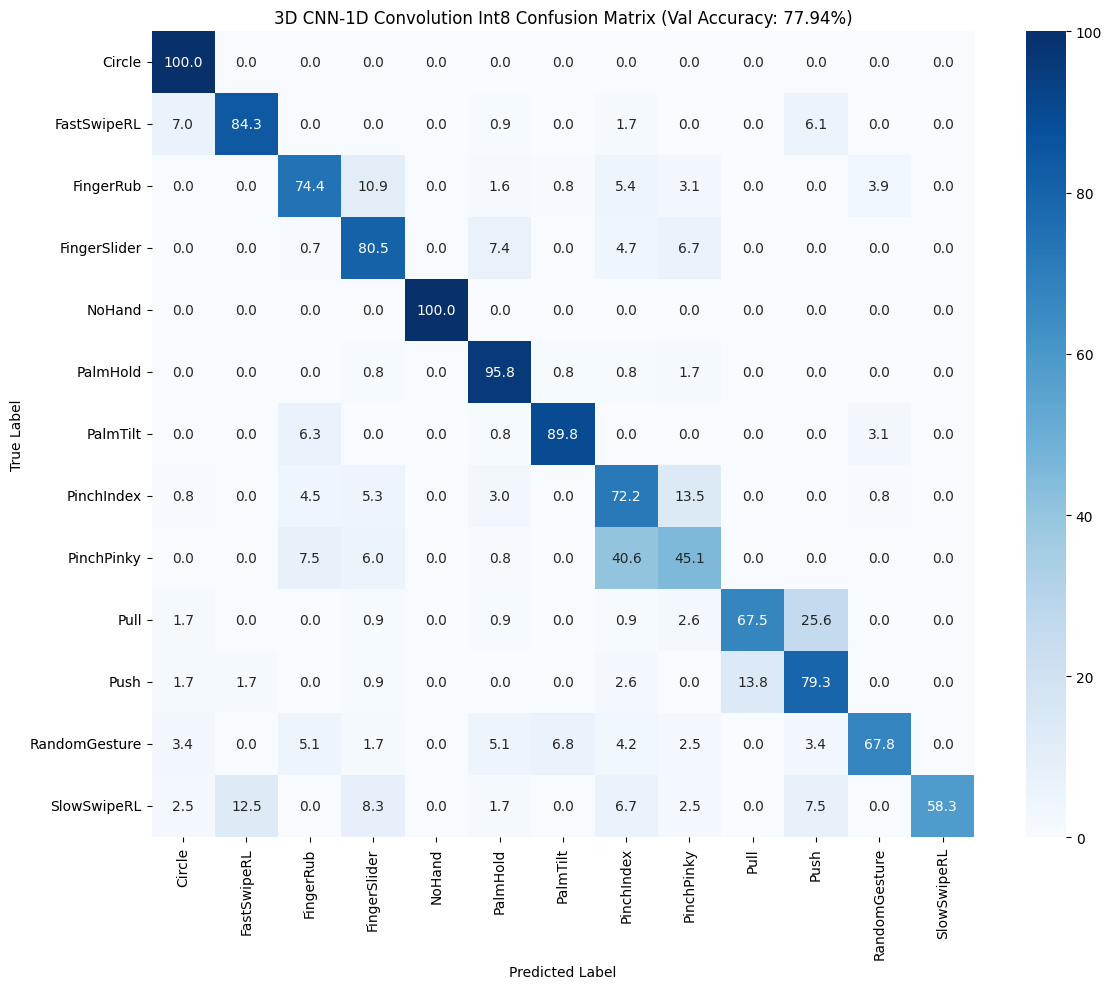

Classification Report:
                precision    recall  f1-score   support

       Circle      0.860     1.000     0.925       123
  FastSwipeRL      0.851     0.843     0.847       115
    FingerRub      0.756     0.744     0.750       129
 FingerSlider      0.732     0.805     0.767       149
       NoHand      1.000     1.000     1.000       124
     PalmHold      0.797     0.958     0.870       119
     PalmTilt      0.919     0.898     0.908       127
   PinchIndex      0.522     0.722     0.606       133
   PinchPinky      0.583     0.451     0.508       133
         Pull      0.832     0.675     0.745       117
         Push      0.648     0.793     0.713       116
RandomGesture      0.889     0.678     0.769       118
  SlowSwipeRL      1.000     0.583     0.737       120

     accuracy                          0.779      1623
    macro avg      0.799     0.781     0.780      1623
 weighted avg      0.795     0.779     0.778      1623



In [87]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="deployable_cnn_model_int8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using TFLite
def predict_tflite_sequence(sequence):
    # Get scale and zero-point for quantization
    scale, zero_point = input_details[0]['quantization']

    # Normalize input (assuming it was float32 [0,1])
    sequence = sequence.astype(np.float32)

    # Quantize to int8
    sequence_q = (sequence / scale + zero_point).astype(np.int8)
    input_tensor = np.expand_dims(sequence_q, axis=0)  # Add batch dim

    # Set and run
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()

    # Dequantize output if needed
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data, axis=1)[0]

# Evaluate on val set
y_true, y_pred = [], []
for X, y in val_gen:
    for i in range(len(X)):
        pred = predict_tflite_sequence(X[i])
        y_true.append(int(y[i]))
        y_pred.append(int(pred))

# Get full label list
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(label_map))]

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# Normalize CM to show percentages
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"3D CNN-1D Convolution Int8 Confusion Matrix (Val Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:\n", report)

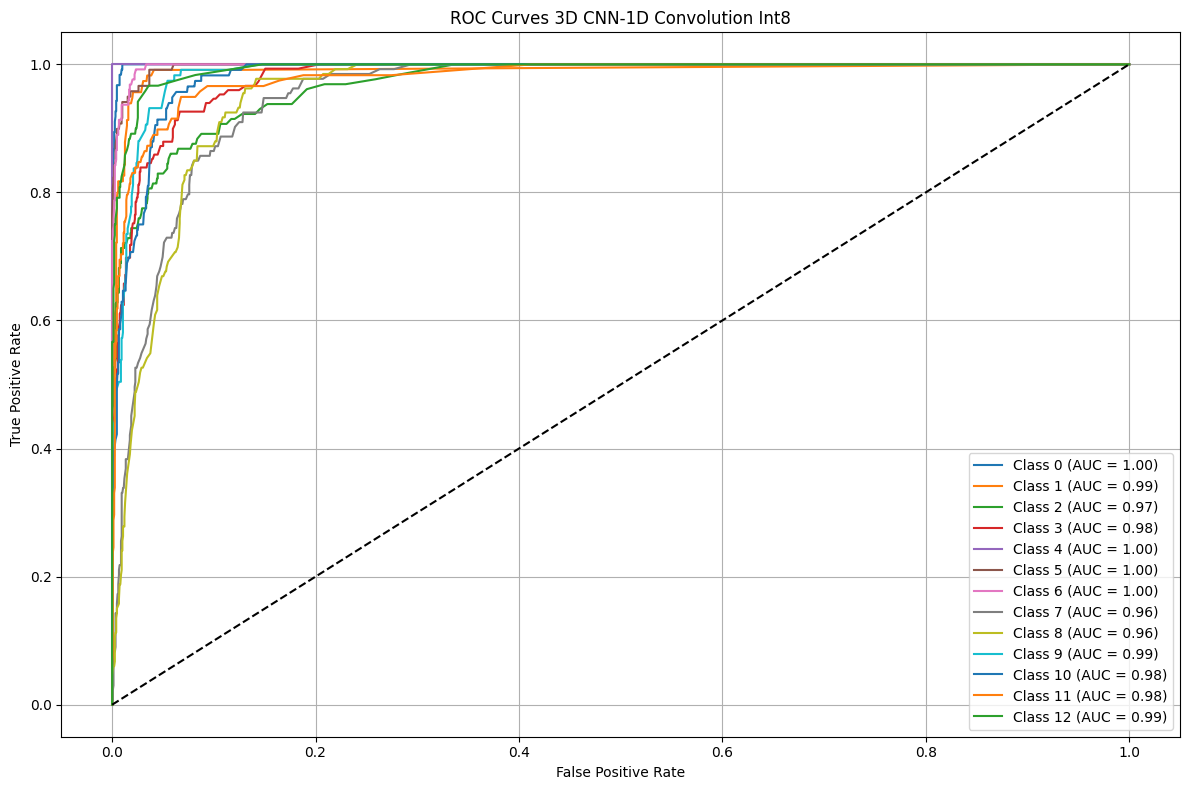

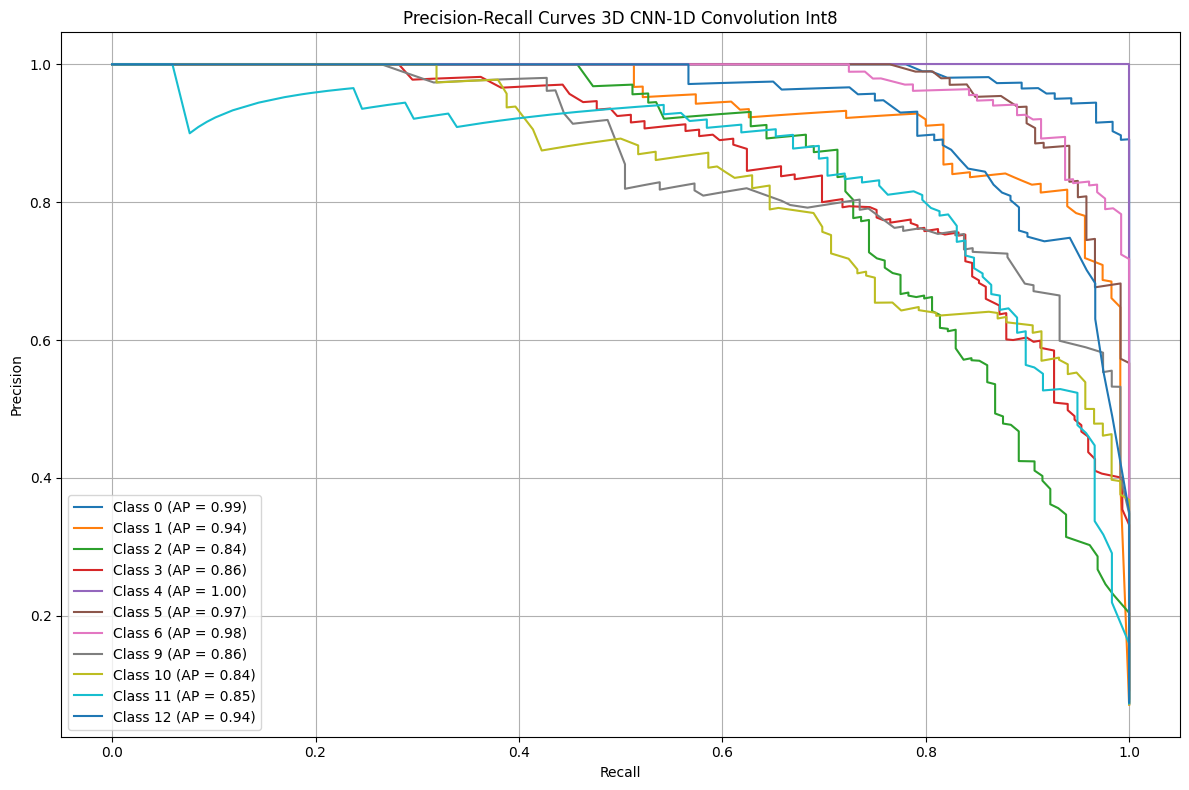

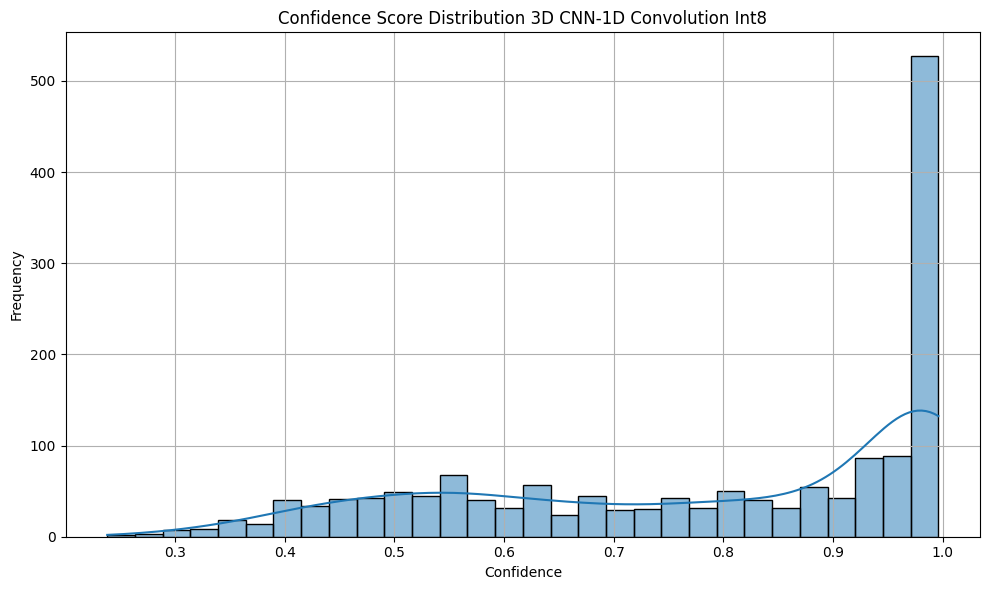

In [ ]:
Load TFLite model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

interpreter = tf.lite.Interpreter(model_path=r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\deployable_cnn_model_int8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite_proba(sequence):
    # Quantization parameters for the input
    scale, zero_point = input_details[0]['quantization']
    
    # Quantize float32 input to int8
    input_tensor = (sequence / scale + zero_point).astype(np.int8)
    input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()

    # Dequantize output (optional but useful for ROC/PR curves)
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    out_scale, out_zero_point = output_details[0]['quantization']
    output_dequant = (output_data.astype(np.float32) - out_zero_point) * out_scale

    return output_dequant

# Gather predictions and scores
y_true, y_scores = [], []
for X_batch, y_batch in val_gen:
    for i in range(len(X_batch)):
        y_true.append(int(y_batch[i]))
        y_scores.append(predict_tflite_proba(X_batch[i]))

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = np.argmax(y_scores, axis=1)

# Convert labels to one-hot for metrics
n_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# ROC Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves 3D CNN-1D Convolution Int8")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP = {avg_precision:.2f})")
plt.title("Precision-Recall Curves 3D CNN-1D Convolution Int8")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Confidence Score Distribution
conf_scores = np.max(y_scores, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(conf_scores, bins=30, kde=True)
plt.title("Confidence Score Distribution 3D CNN-1D Convolution Int8")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid()
plt.show()

# Making Data for Validation

In [72]:
scale, zero_point = output_details[0]['quantization']
print(f"Output scale: {scale}, zero_point: {zero_point}")

Output scale: 0.00390625, zero_point: -128


In [73]:
def save_int8_csv_for_validation(generator, label_map, output_dir="csv_validation_data", samples_per_gesture=3):
    import os
    os.makedirs(output_dir, exist_ok=True)

    scale = 0.00390625
    zero_point = -128
    gesture_counts = {label: 0 for label in label_map.values()}

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            gesture_id = label + 1
            sample_num = gesture_counts[label] + 1
            base_name = f"gesture{gesture_id}_{sample_num}"

            # Prepare and quantize input
            input_data = X_batch[i].astype(np.float32)
            input_data = np.expand_dims(input_data, axis=0)  # (1, 480, 32, 1)
            int8_data = np.clip(np.round(input_data / scale + zero_point), -128, 127).astype(np.int8)
            flat_int8 = int8_data.flatten()

            # Save input as CSV (int8, comma-separated)
            input_path = os.path.join(output_dir, f"{base_name}_input.csv")
            np.savetxt(input_path, [flat_int8], fmt='%d', delimiter=',')

            # Save label (optional)
            output_path = os.path.join(output_dir, f"{base_name}_output.csv")
            with open(output_path, "w") as f:
                f.write(f"{label}")

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            print(f" Exported {samples_per_gesture} CSV samples per gesture to '{output_dir}'")
            return

In [74]:
save_int8_csv_for_validation(train_gen, label_map, output_dir="3_cnn_1dc_val_data", samples_per_gesture=3)

 Exported 3 CSV samples per gesture to '3_cnn_1dc_val_data'


In [ ]:
def save_float32_csv_for_validation(generator, label_map, output_dir="csv_validation_data", samples_per_gesture=3):
    import os
    os.makedirs(output_dir, exist_ok=True)

    gesture_counts = {label: 0 for label in label_map.values()}

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            gesture_id = label + 1
            sample_num = gesture_counts[label] + 1
            base_name = f"gesture{gesture_id}_{sample_num}"

            # Normalize input [0, 1] and flatten
            input_data = X_batch[i].astype(np.float32)
            input_data = np.expand_dims(input_data, axis=0)  # (1, 480, 32, 1)
            flat_input = input_data.flatten()

            # Save input as CSV (float32, comma-separated)
            input_path = os.path.join(output_dir, f"{base_name}_input.csv")
            np.savetxt(input_path, [flat_input], fmt='%.6f', delimiter=',')

            # Save label (optional)
            output_path = os.path.join(output_dir, f"{base_name}_output.csv")
            with open(output_path, "w") as f:
                f.write(f"{label}")

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            print(f" Exported {samples_per_gesture} CSV samples per gesture to '{output_dir}'")
            return

In [84]:
def save_float32_csv_for_validation_one_file(generator, label_map, output_dir="csv_validation_data", samples_per_gesture=3):
    import os
    import numpy as np

    os.makedirs(output_dir, exist_ok=True)

    gesture_counts = {label: 0 for label in label_map.values()}
    all_inputs = []
    all_labels = []

    num_classes = len(label_map)

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            # Flatten input (already in [0, 1] float32)
            input_data = X_batch[i]
            flat_input = input_data.flatten()
            all_inputs.append(flat_input)

            # One-hot encode label
            one_hot = np.zeros(num_classes, dtype=int)
            one_hot[label] = 1
            all_labels.append(one_hot)

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            break

    # Save to CSV
    input_path = os.path.join(output_dir, "all_inputs.csv")
    label_path = os.path.join(output_dir, "all_labels.csv")

    np.savetxt(input_path, all_inputs, fmt='%.6f', delimiter=',')
    np.savetxt(label_path, all_labels, fmt='%d', delimiter=',')

    print(f"Saved {len(all_inputs)} samples to:")
    print(f"  → {input_path}")
    print(f"  → {label_path}")


In [ ]:
save_float32_csv_for_validation(train_gen, label_map, output_dir="3_cnn_1dc_val_data_float32", samples_per_gesture=3)

In [86]:
save_float32_csv_for_validation_one_file(val_gen, label_map, output_dir="3_cnn_1dc_val_data_float32_ten", samples_per_gesture=10)

Saved 130 samples to:
  → 3_cnn_1dc_val_data_float32_ten\all_inputs.csv
  → 3_cnn_1dc_val_data_float32_ten\all_labels.csv


In [53]:
label_map

{'Circle': 0,
 'FastSwipeRL': 1,
 'FingerRub': 2,
 'FingerSlider': 3,
 'NoHand': 4,
 'PalmHold': 5,
 'PalmTilt': 6,
 'PinchIndex': 7,
 'PinchPinky': 8,
 'Pull': 9,
 'Push': 10,
 'RandomGesture': 11,
 'SlowSwipeRL': 12}